# TimeGAN Example Usage

This notebook demonstrates how to use TimeGAN to generate synthetic time series data.

## Steps:
1. Generate mock stochastic exponential time series data (Geometric Brownian Motion)
2. Preprocess data using preprocessing utilities
3. Train TimeGAN model
4. Generate synthetic samples


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys

project_root = Path().resolve().parents[0].parents[0]
sys.path.append(str(project_root))

from src.models.non_parametric.time_gan import TimeGAN
from src.utils.preprocessing_utils import (
    LogReturnTransformation,
    preprocess_non_parametric,
    create_dataloaders
)


## Step 1: Generate Mock Stochastic Exponential Time Series Data

We'll generate a Geometric Brownian Motion (GBM) time series, which is commonly used for modeling stock prices.


Generated 10001 days of price data
Price range: [74.61, 232.27]


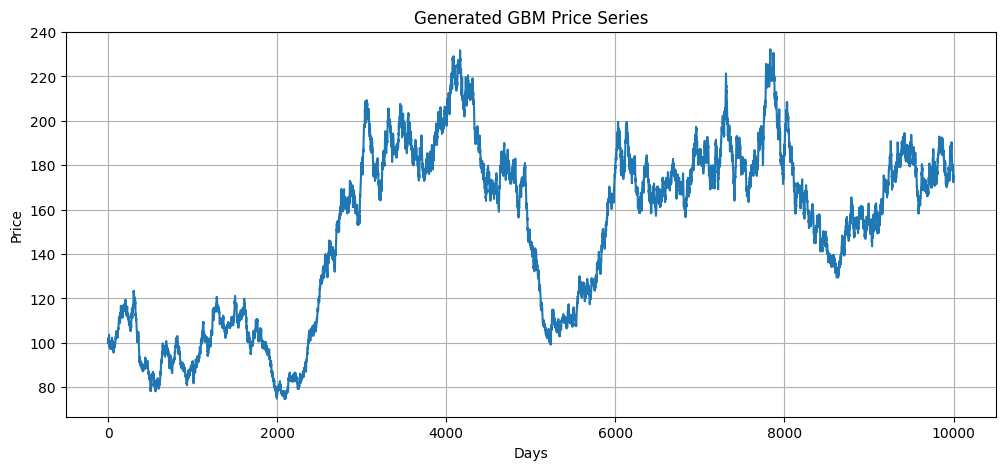

In [2]:
def generate_gbm_prices(
    initial_price: float = 100.0,
    mu: float = 0.05,  # Annual drift
    sigma: float = 0.2,  # Annual volatility
    num_days: int = 1000,
    dt: float = 1/252,  # Daily time step (252 trading days per year)
    seed: int = 42
) -> torch.Tensor:
    """
    Generate Geometric Brownian Motion price series.
    
    Args:
        initial_price: Starting price
        mu: Annual drift rate
        sigma: Annual volatility
        num_days: Number of days to simulate
        dt: Time step (default: daily)
        seed: Random seed
    
    Returns:
        Price series as torch.Tensor
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    # Generate random shocks
    Z = torch.randn(num_days)
    
    # GBM: dS = mu*S*dt + sigma*S*dW
    # In log space: d(log S) = (mu - 0.5*sigma^2)*dt + sigma*dW
    log_returns = (mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z
    
    # Convert log returns to prices
    log_prices = torch.cumsum(torch.cat([torch.tensor([np.log(initial_price)]), log_returns]), dim=0)
    prices = torch.exp(log_prices)
    
    return prices

# Generate synthetic price data
original_prices = generate_gbm_prices(
    initial_price=100.0,
    mu=0.03,  # 8% annual return
    sigma=0.15,  # 25% annual volatility
    num_days=10000,
    seed=40
)

print(f"Generated {len(original_prices)} days of price data")
print(f"Price range: [{original_prices.min():.2f}, {original_prices.max():.2f}]")

# Visualize the generated data
plt.figure(figsize=(12, 5))
plt.plot(original_prices.numpy())
plt.title('Generated GBM Price Series')
plt.xlabel('Days')
plt.ylabel('Price')
plt.grid(True)
plt.show()


## Step 2: Preprocess Data

Convert prices to log returns and create sliding windows for non-parametric models.


Log returns shape: torch.Size([10000])
Log returns stats: mean=0.000056, std=0.009374

Preprocessed data shapes:
Train: torch.Size([7920, 100])
Valid: torch.Size([990, 100])
Test: torch.Size([991, 100])


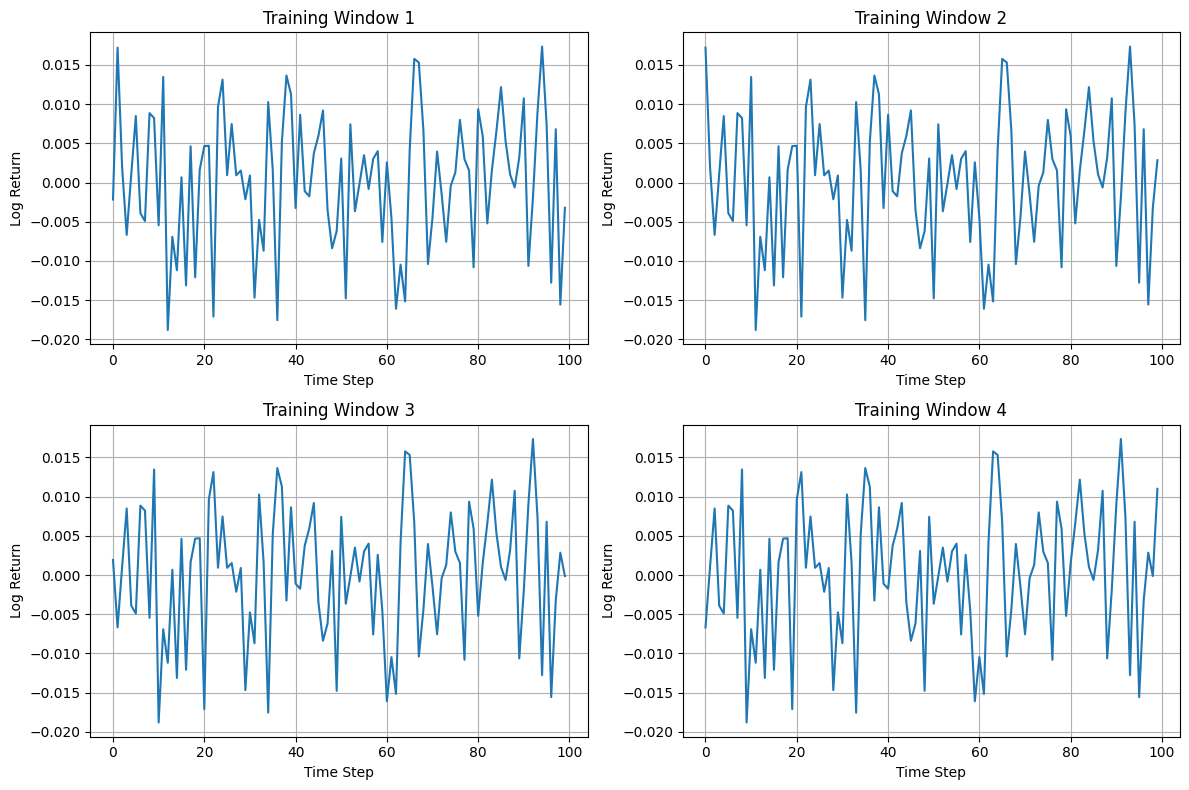

In [3]:
# Convert prices to log returns
scaler = LogReturnTransformation()
log_returns, initial_value = scaler.transform(original_prices)

print(f"Log returns shape: {log_returns.shape}")
print(f"Log returns stats: mean={log_returns.mean():.6f}, std={log_returns.std():.6f}")

# Preprocess for non-parametric model
seq_length = 100  # Window size for time series
train_data, valid_data, test_data, train_initial, valid_initial, test_initial = preprocess_non_parametric(
    ori_data=log_returns,
    original_prices=original_prices,
    seq_length=seq_length,
    valid_ratio=0.1,
    test_ratio=0.1,
    stride=1
)

print(f"\nPreprocessed data shapes:")
print(f"Train: {train_data.shape}")
print(f"Valid: {valid_data.shape}")
print(f"Test: {test_data.shape}")

# Visualize a few training windows
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()
for i in range(4):
    axes[i].plot(train_data[i].numpy())
    axes[i].set_title(f'Training Window {i+1}')
    axes[i].set_xlabel('Time Step')
    axes[i].set_ylabel('Log Return')
    axes[i].grid(True)
plt.tight_layout()
plt.show()


## Step 3: Create DataLoaders

Create PyTorch DataLoaders for training.


In [4]:
# Create DataLoaders
batch_size = 128
train_loader, valid_loader, test_loader = create_dataloaders(
    train_data=train_data,
    valid_data=valid_data,
    test_data=test_data,
    batch_size=batch_size,
    train_initial=train_initial,
    valid_initial=valid_initial,
    test_initial=test_initial,
    num_workers=0,
    pin_memory=False
)

print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

# Check batch shape
sample_batch, sample_initial = next(iter(train_loader))
print(f"\nBatch shape: {sample_batch.shape}")
print(f"Initial values shape: {sample_initial.shape}")


Number of training batches: 62
Number of validation batches: 8
Number of test batches: 8

Batch shape: torch.Size([128, 100])
Initial values shape: torch.Size([128])


## Step 4: Initialize and Train TimeGAN

Create TimeGAN model and train it on the preprocessed data.


In [5]:
# Initialize TimeGAN model
model = TimeGAN(
    seq_len=seq_length,
    learning_rate=1e-3,
    batch_size=batch_size,
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

print(f"TimeGAN model initialized on device: {model.device}")


TimeGAN model initialized on device: cpu


In [ ]:
print("Starting TimeGAN training...")
print("Note: TimeGAN training has 3 stages, each with num_epochs iterations")
print("This may take a while - be patient!")
model.fit(
    data_loader=train_loader,
    num_epochs=10000
)
print("\nTraining complete!")


Starting TimeGAN training...
Note: TimeGAN training has 3 stages, each with num_epochs iterations
This may take a while - be patient!
Preprocessing data...
Start Embedding Network Training
epoch: 0/10000, e_loss: 0.2142
epoch: 1000/10000, e_loss: 0.1465
epoch: 2000/10000, e_loss: 0.1444
epoch: 3000/10000, e_loss: 0.0127
epoch: 4000/10000, e_loss: 0.0056
epoch: 5000/10000, e_loss: 0.0054
epoch: 6000/10000, e_loss: 0.0039
epoch: 7000/10000, e_loss: 0.0052
epoch: 8000/10000, e_loss: 0.0022
epoch: 9000/10000, e_loss: 0.0047
Finish Embedding Network Training
Start Training with Supervised Loss Only
epoch: 0/10000, g_loss_s: 0.2213
epoch: 1000/10000, g_loss_s: 0.0178
epoch: 2000/10000, g_loss_s: 0.0151
epoch: 3000/10000, g_loss_s: 0.0147
epoch: 4000/10000, g_loss_s: 0.0144
epoch: 5000/10000, g_loss_s: 0.0142
epoch: 6000/10000, g_loss_s: 0.0139
epoch: 7000/10000, g_loss_s: 0.0143
epoch: 8000/10000, g_loss_s: 0.014
epoch: 9000/10000, g_loss_s: 0.0142
Finish Training with Supervised Loss Only
S

## Step 5: Generate Synthetic Samples

Generate synthetic time series samples using the trained model.


In [ ]:
# Generate synthetic samples
num_samples = 10
generation_length = seq_length

print(f"Generating {num_samples} synthetic samples of length {generation_length}...")
generated_samples = model.generate(
    num_samples=num_samples,
    generation_length=generation_length,
    seed=123
)

print(f"Generated samples shape: {generated_samples.shape}")
print(f"Generated samples stats: mean={generated_samples.mean():.6f}, std={generated_samples.std():.6f}")

# Compare with real data
print(f"\nReal data stats: mean={train_data.mean():.6f}, std={train_data.std():.6f}")


Generating 10 synthetic samples of length 100...
Generated samples shape: torch.Size([10, 100])
Generated samples stats: mean=0.000000, std=0.000363

Real data stats: mean=0.000080, std=0.009369


## Step 6: Visualize Results

Compare generated samples with real training data.


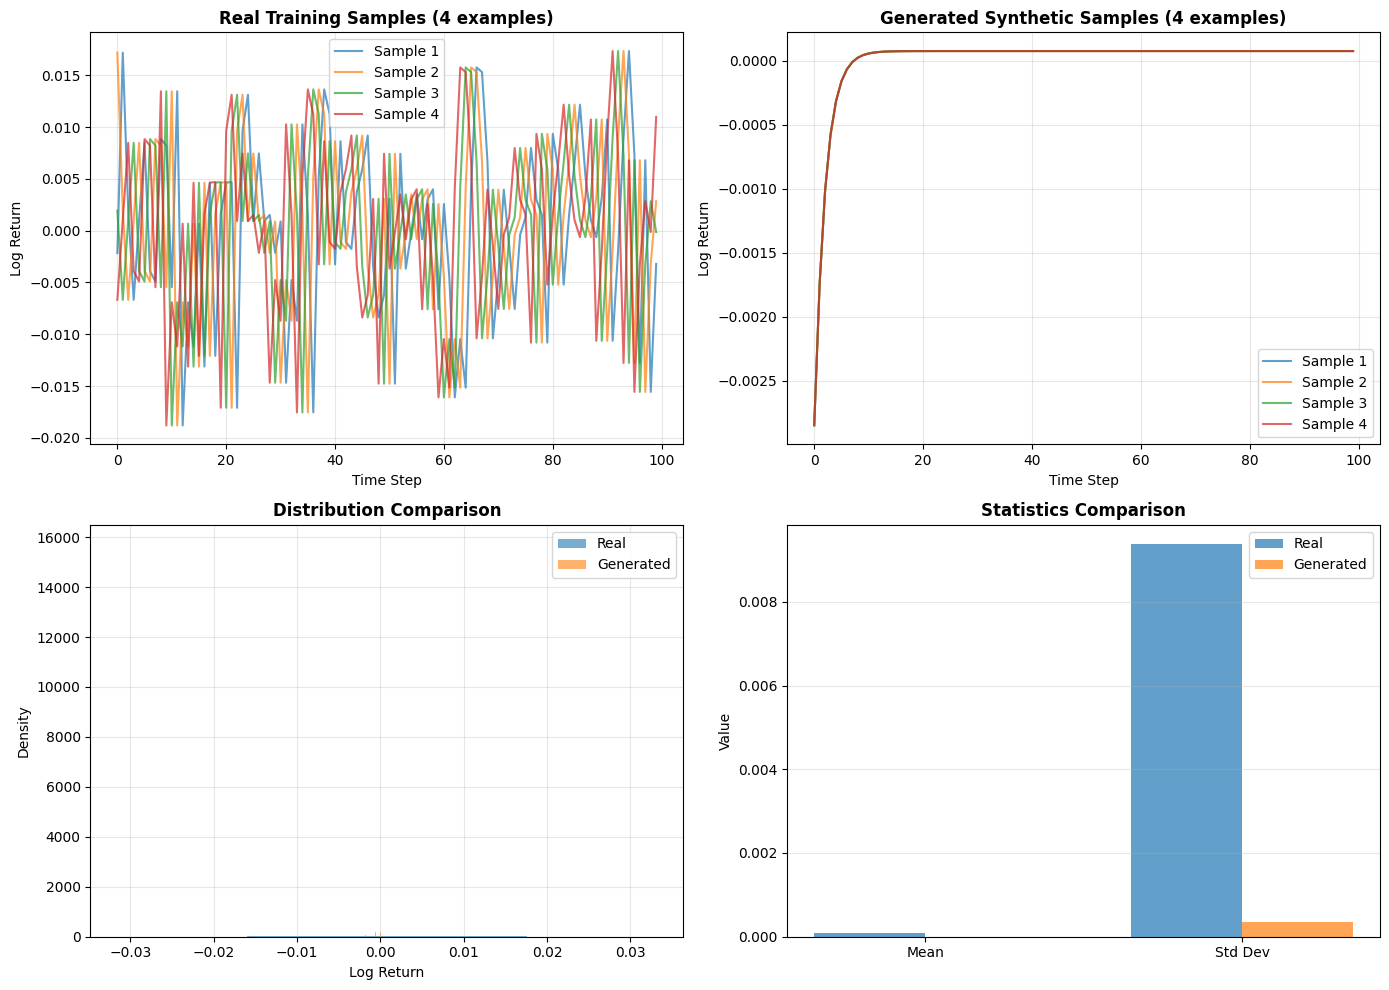


Statistics Summary:
Real data - Mean: 0.000080, Std: 0.009369
Generated - Mean: 0.000000, Std: 0.000363


In [ ]:
# Visualize generated vs real samples
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Real training samples
axes[0, 0].set_title('Real Training Samples (4 examples)', fontsize=12, fontweight='bold')
for i in range(min(4, len(train_data))):
    axes[0, 0].plot(train_data[i].numpy(), alpha=0.7, label=f'Sample {i+1}')
axes[0, 0].set_xlabel('Time Step')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Plot 2: Generated samples
axes[0, 1].set_title('Generated Synthetic Samples (4 examples)', fontsize=12, fontweight='bold')
for i in range(min(4, num_samples)):
    axes[0, 1].plot(generated_samples[i].numpy(), alpha=0.7, label=f'Sample {i+1}')
axes[0, 1].set_xlabel('Time Step')
axes[0, 1].set_ylabel('Log Return')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# Plot 3: Distribution comparison
axes[1, 0].set_title('Distribution Comparison', fontsize=12, fontweight='bold')
axes[1, 0].hist(train_data.flatten().numpy(), bins=50, alpha=0.6, label='Real', density=True)
axes[1, 0].hist(generated_samples.flatten().numpy(), bins=50, alpha=0.6, label='Generated', density=True)
axes[1, 0].set_xlabel('Log Return')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Statistics comparison
axes[1, 1].set_title('Statistics Comparison', fontsize=12, fontweight='bold')
real_mean = train_data.mean().item()
real_std = train_data.std().item()
gen_mean = generated_samples.mean().item()
gen_std = generated_samples.std().item()

categories = ['Mean', 'Std Dev']
real_stats = [real_mean, real_std]
gen_stats = [gen_mean, gen_std]

x = np.arange(len(categories))
width = 0.35

axes[1, 1].bar(x - width/2, real_stats, width, label='Real', alpha=0.7)
axes[1, 1].bar(x + width/2, gen_stats, width, label='Generated', alpha=0.7)
axes[1, 1].set_ylabel('Value')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"\nStatistics Summary:")
print(f"Real data - Mean: {real_mean:.6f}, Std: {real_std:.6f}")
print(f"Generated - Mean: {gen_mean:.6f}, Std: {gen_std:.6f}")


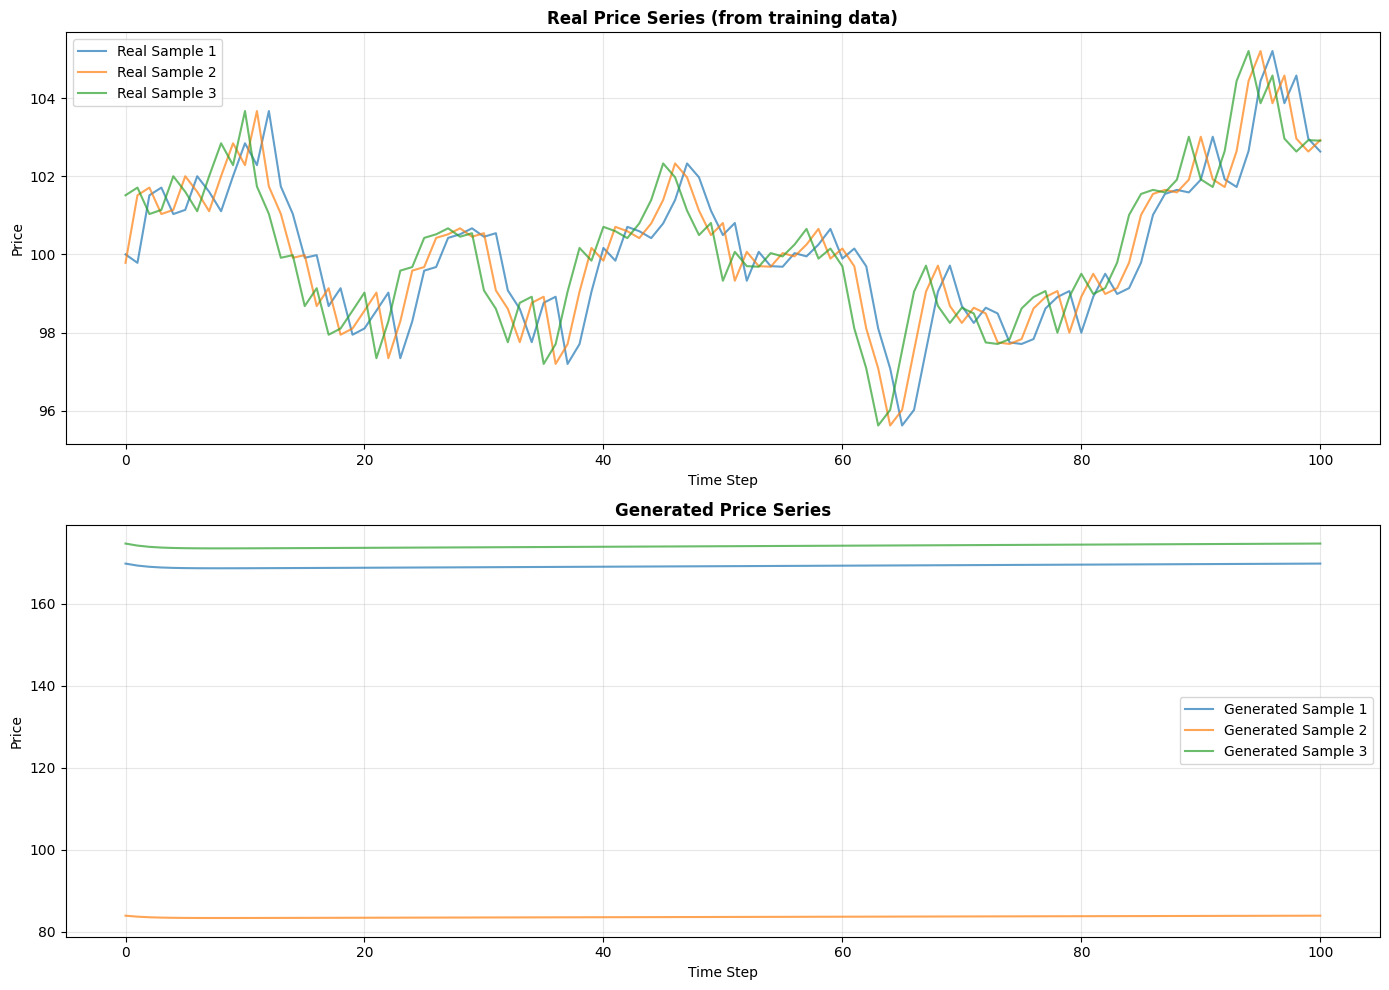


Successfully generated synthetic time series data!


In [ ]:
# Convert generated log returns back to prices
generated_prices_list = []
for i in range(num_samples):
    # Use a random initial price from the training data
    initial_price = train_initial[torch.randint(0, len(train_initial), (1,))].item()
    
    # Reconstruct prices from log returns
    prices = scaler.inverse_transform(generated_samples[i], torch.tensor(initial_price))
    generated_prices_list.append(prices)

# Visualize price series
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Real price series (reconstructed from training data)
axes[0].set_title('Real Price Series (from training data)', fontsize=12, fontweight='bold')
for i in range(min(3, len(train_data))):
    prices = scaler.inverse_transform(train_data[i], train_initial[i])
    axes[0].plot(prices.numpy(), alpha=0.7, label=f'Real Sample {i+1}')
axes[0].set_xlabel('Time Step')
axes[0].set_ylabel('Price')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Generated price series
axes[1].set_title('Generated Price Series', fontsize=12, fontweight='bold')
for i, prices in enumerate(generated_prices_list[:3]):
    axes[1].plot(prices.numpy(), alpha=0.7, label=f'Generated Sample {i+1}')
axes[1].set_xlabel('Time Step')
axes[1].set_ylabel('Price')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSuccessfully generated synthetic time series data!")
